In [1]:
import pingouin as pg
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import seaborn
import math

from os import listdir
from os.path import dirname, join

In [2]:
runs = ['run1_15_time_pts']
all_Rscore = []

for run in runs:
    file = 'E:/'+run+'/Rscore/Rscore_1.csv'
    Rscore = pd.read_csv(file)
    Rscore = Rscore.rename(columns={'Unnamed: 0':'ID'})
    Rscore = Rscore.set_index('ID')
    for i in range(2,21):
        file = 'E:/'+run+'/Rscore/Rscore_'+str(i)+'.csv'
        tmp2 = pd.read_csv(file)
        tmp2 = tmp2.rename(columns={'Unnamed: 0':'ID'})
        tmp2 = tmp2.set_index('ID')
        Rscore = pd.concat([Rscore, tmp2],sort=True)

    # sort regions by region number
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:int(reg.strip('region '))})
    Rscore = Rscore.sort_index(axis=1)
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:'region '+str(reg)})
    
    # sort by subject ID and save to file
    #Rscore.to_csv('E:/projects/connectome/results/'+run+'/Rscore/Rscore_all.csv',index=True)
    
    all_Rscore.append(Rscore)

D:\anaconda\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
all_Rscore[0] = all_Rscore[0].sort_index()
all_Rscore[0].index = list(range(1,len(all_Rscore[0].index)+1))
all_Rscore[0].columns = list(range(1,len(all_Rscore[0].columns)+1))

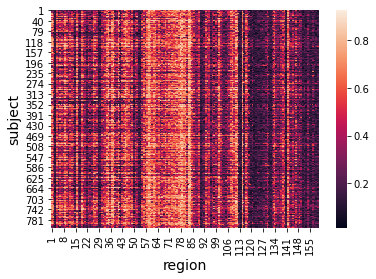

In [4]:
seaborn.heatmap(all_Rscore[0])
plt.xlabel('region',fontsize=14)
plt.ylabel('subject',fontsize=14)
plt.show()

In [5]:
# fill the corresponding weight of a failing order by zero
def fill_missing_with_zero(reg_orders_and_weights): 
    # don't change the order triplet (p,d,q) to (p,q) even if we do not need d here, it will lead to bugs
    order_to_index = {(1,0,1):0, (2,0,2):1, (3,0,3):2, (4,0,4):3, (5,0,5):4, (6,0,6):5,
                      (7,0,7):6, (8,0,8):7, (9,0,9):8, (10,0,10):9, (11,0,11):10,(12,0,12):11,
                      (13,0,13):12,(14,0,14):13}
    
    # the orders are stored as a nested list of either list or ndarray, we need to make them all into nested lists
    reg_orders = reg_orders_and_weights[0]
    tmp = []
    for order in reg_orders:
        if isinstance(order[0],np.int64):
            tmp.append(tuple(order))
        else:
            tmp.append(tuple(order[0]))
    reg_orders =tmp
    
    # the weights are stored as a nested list of either list of ndarray, we need to make them all into nested lists
    reg_weights = reg_orders_and_weights[1]
    if len(reg_weights)==1:
        reg_weights = reg_weights.tolist()[0]
    else:
        reg_weights = reg_weights.tolist()
    
    # filling up the missing orders and make the corresponding weights zero
    for order in order_to_index:
        if not order in reg_orders:
            reg_weights.insert(order_to_index[order],0)
            reg_orders.insert(order_to_index[order],order)
    
    return reg_orders,reg_weights

In [6]:
# making correspondence between a certain row to a subject ID (this is for potential later usage)
# row_num_to_subID[r] stores the ID of the subject whose data is stored in row r
row_to_subID = {}

In [7]:
#file_dir = 'E:/projects/connectome/results/run1/ensemble_orders_and_weights'
file_dir = 'E:/run1_15_time_pts/ensemble_orders_and_weights'
file_names = listdir(file_dir)

all_orders = []
all_weights = []

for i,file_name in enumerate(file_names):
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    
    # putting row num into 1-to-1 correspondence to subject ID
    row_to_subID[i]=ID_num
    
    
    file = join(file_dir,file_name)
    sub_orders_and_weights = scipy.io.loadmat(file)['ensemble_orders_and_weights']
    
    sub_orders = []
    sub_weights = []
    
    for reg in range(160):
        reg_orders, reg_weights = fill_missing_with_zero(sub_orders_and_weights[reg])
        sub_orders.append(reg_orders)
        sub_weights.append(reg_weights)
    
    all_orders.append(sub_orders)
    all_weights.append(sub_weights)

In [8]:
# make all_weights into a 2D array as it was an messy embeding of ndarray and array
tmp = [[None for _ in range(160)] for _ in range(len(all_orders))]
for sub in range(len(all_orders)):
    for reg in range(160): 
        if not isinstance(all_weights[sub][reg][0],float) and not isinstance(all_weights[sub][reg][0],int):
            if not isinstance(all_weights[sub][reg][0][0],float) and not isinstance(all_weights[sub][reg][0][0],int):
                if not isinstance(all_weights[sub][reg][0][0],float) and not isinstance(all_weights[sub][reg][0][0],int):
                    if not isinstance(all_weights[sub][reg][0][0][0],float) and not isinstance(all_weights[sub][reg][0][0][0],int):
                        tmp[sub][reg] = [all_weights[sub][reg][i][0][0] for i in range(14)] 
                else:
                    tmp[sub][reg] = [all_weights[sub][reg][i][0] for i in range(14)]
            else:
                tmp[sub][reg] = [all_weights[sub][reg][i] for i in range(14)]
        else:
            tmp[sub][reg] = all_weights[sub][reg]

In [9]:
# make all_weights into a 2D array as it was an messy embedded data type of ndarray and array
tmp = [[None for _ in range(160)] for _ in range(len(all_orders))]
for sub in range(len(all_orders)):
    for reg in range(160): 
        if not isinstance(all_weights[sub][reg][0],float) and not isinstance(all_weights[sub][reg][0],int):
            tmp[sub][reg] = [all_weights[sub][reg][i][0][0] for i in range(14)] 
        else:
            tmp[sub][reg] = all_weights[sub][reg]
all_weights = tmp

In [10]:
order_sum_of_best_model = []
for sub in range(len(all_weights)):
    tmp = []
    for reg in range(len(all_weights[0])):
        max_weight = max(all_weights[sub][reg])
        all_weights_sub_reg = list(all_weights[sub][reg])
        max_weight_index = all_weights_sub_reg.index(max_weight)
        tmp.append(sum(all_orders[sub][reg][max_weight_index]))
    order_sum_of_best_model.append(tmp)
order_sum_of_best_model = pd.DataFrame(order_sum_of_best_model)
order_sum_of_best_model.index = range(1,len(order_sum_of_best_model.index)+1)
order_sum_of_best_model.columns = range(1,len(order_sum_of_best_model.columns)+1)


In [11]:
p_of_best_model = []
for sub in range(len(all_weights)):
    tmp = []
    for reg in range(len(all_weights[0])):
        max_weight = max(all_weights[sub][reg])
        all_weights_sub_reg = list(all_weights[sub][reg])
        max_weight_index = all_weights_sub_reg.index(max_weight)
        tmp.append(all_orders[sub][reg][max_weight_index][0])
    p_of_best_model.append(tmp)
p_of_best_model = pd.DataFrame(p_of_best_model)
p_of_best_model.index = range(1,len(p_of_best_model.index)+1)
p_of_best_model.columns = range(1,len(p_of_best_model.columns)+1)


In [12]:
q_of_best_model = []
for sub in range(len(all_weights)):
    tmp = []
    for reg in range(len(all_weights[0])):
        max_weight = max(all_weights[sub][reg])
        all_weights_sub_reg = list(all_weights[sub][reg])
        max_weight_index = all_weights_sub_reg.index(max_weight)
        tmp.append(all_orders[sub][reg][max_weight_index][2])
    q_of_best_model.append(tmp)
q_of_best_model = pd.DataFrame(q_of_best_model)
q_of_best_model.index = range(1,len(q_of_best_model.index)+1)
q_of_best_model.columns = range(1,len(q_of_best_model.columns)+1)


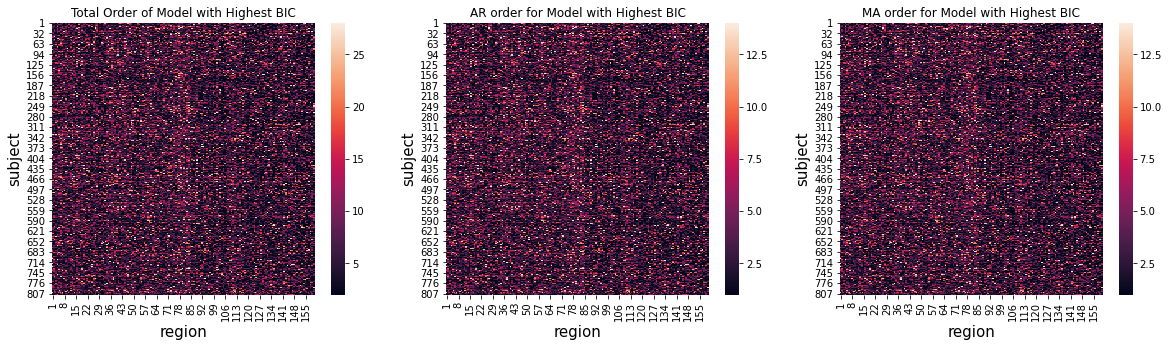

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
seaborn.heatmap(order_sum_of_best_model,ax=axes[0])
seaborn.heatmap(p_of_best_model,ax=axes[1])
seaborn.heatmap(q_of_best_model,ax=axes[2])
axes[0].set_title('Total Order of Model with Highest BIC')
axes[0].set_xlabel('region',fontsize=15)
axes[0].set_ylabel('subject',fontsize=15)
axes[1].set_title('AR order for Model with Highest BIC')
axes[1].set_xlabel('region',fontsize=15)
axes[1].set_ylabel('subject',fontsize=15)
axes[2].set_title('MA order for Model with Highest BIC')
axes[2].set_xlabel('region',fontsize=15)
axes[2].set_ylabel('subject',fontsize=15)
plt.show()

In [14]:
order_to_index = {(1,1):0, (2,2):1, (3,3):2, (4,4):3, (5,5):4, (6,6):5,
                  (7,7):6, (8,8):7, (9,9):8, (10,10):9, (11,11):10,(12,12):11,
                  (13,13):12,(14,14):13}
model_weights = {}
model_col_names = [model for model in order_to_index]
for model in range(14):
    model_weights_matrix = []
    for sub in range(len(all_orders)):
        sub_weight_of_regions = [all_weights[sub][i][model] for i in range(160)]
        model_weights_matrix.append(sub_weight_of_regions)
    
    # obtain model order
    model_order = model_col_names[model]
    p = model_order[0]
    q = model_order[1]
    # hash based on (p,q)
    model_weights[tuple([p,q])] = model_weights_matrix
model_weights[(15,15)] = model_weights[(14,14)]

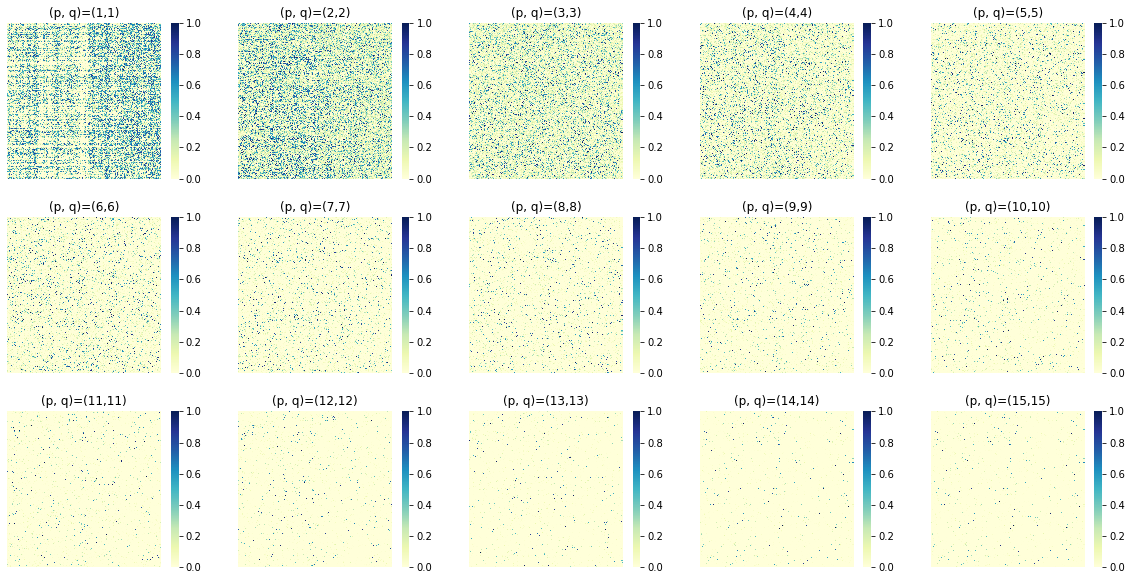

In [15]:
fig, axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
for p in range(15):
    row = p//5
    col = p%5
    seaborn.heatmap(model_weights[(p+1,p+1)],vmax=1,ax=axes[row,col],cmap="YlGnBu")
    axes[row,col].set_title('(p, q)=({},{})'.format(p+1,p+1))
    axes[row,col].axis('off')
    
fig.subplots_adjust(hspace=0.25)
plt.show()


In [21]:
avg_weight_across_sub_for_models = []
for model in model_weights:
    reg_avg = []
    for reg in range(len(model_weights[model][0])):
        sub_weight_sum_in_reg = sum(model_weights[model][sub][reg] for sub in range(len(model_weights[model])))
        sub_weight_avg_in_reg = sub_weight_sum_in_reg/len(model_weights[model])
        reg_avg.append(sub_weight_avg_in_reg)
    avg_weight_across_sub_for_models.append(reg_avg)

In [26]:
len(avg_weight_across_sub_for_models[0])

160

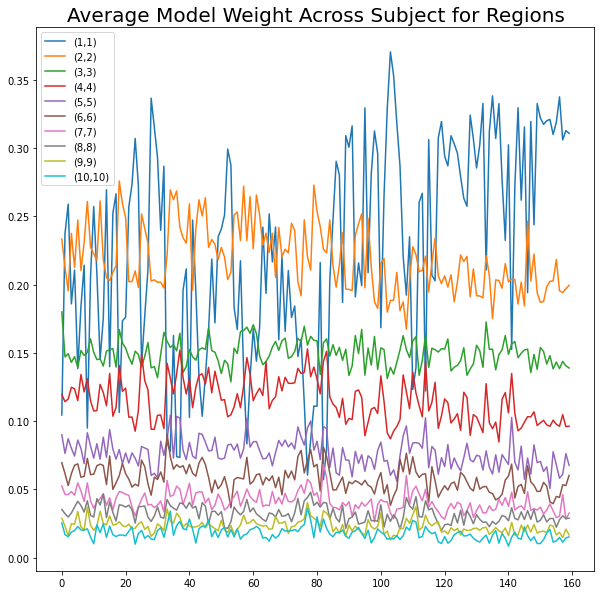

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(10):
    ax.plot(avg_weight_across_sub_for_models[i],label='('+str(i+1)+','+str(i+1)+')')
    ax.set_title('Average Model Weight Across Subject for Regions',fontsize=20)
plt.legend()
plt.show()